# **TL;DR **
At first we wanted to create a predictor for patient to use to predict how much time they'll have to wait for their next action (blood test , dr checkup , consulting etc) but after examining the data further we found that those action have static time that does not take affect by the "heat" (number of action per hour) So we had to think on a new sights we can contribute after looking further into the data we belive that we can predict number of action

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/ED_full_data(in).csv')

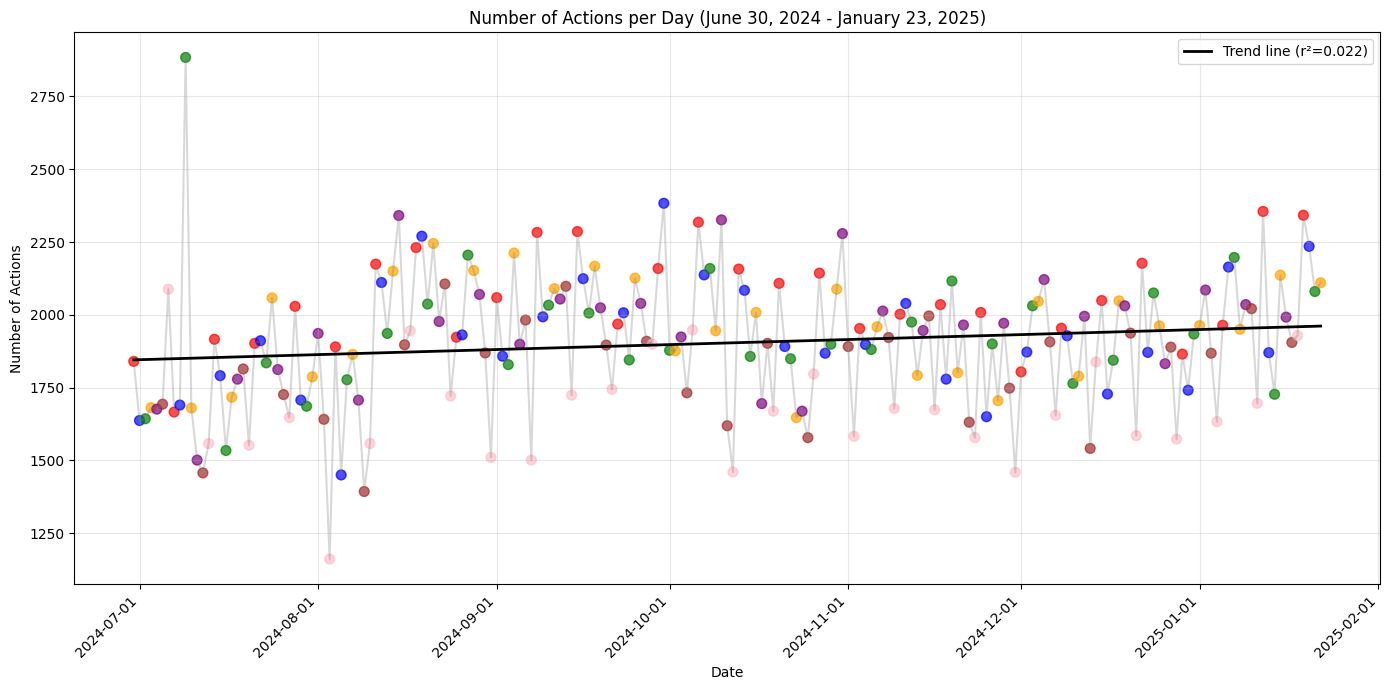

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
start_date = pd.to_datetime('2024-06-30').tz_localize('UTC')
end_date = pd.to_datetime('2025-01-23').tz_localize('UTC')
filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Count rows by day
daily_counts = filtered_df.groupby(pd.Grouper(key='timestamp', freq='D')).size()

# Create a scatter plot
plt.figure(figsize=(14, 7))

# Map days of the week to colors
colors = {
    0: 'blue',     # Monday
    1: 'green',    # Tuesday
    2: 'orange',   # Wednesday
    3: 'purple',   # Thursday
    4: 'brown',    # Friday
    5: 'pink',     # Saturday
    6: 'red',      # Sunday
}

# Get weekday for each date
weekdays = daily_counts.index.dayofweek
day_colors = [colors[day] for day in weekdays]

# Scatter plot with weekday-based colors
plt.scatter(daily_counts.index, daily_counts.values, c=day_colors, alpha=0.7, s=50)

# Connect points with a light line to show the trend
plt.plot(daily_counts.index, daily_counts.values, alpha=0.3, color='gray', linestyle='-')

# Add regression line
x_numeric = np.array(range(len(daily_counts)))
y = daily_counts.values
slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, y)
regression_line = slope * x_numeric + intercept

plt.plot(daily_counts.index, regression_line, 'black', linewidth=2,
         label=f'Trend line (r²={r_value**2:.3f})')

plt.legend()

# Format the plot
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Number of Actions')
plt.title('Number of Actions per Day (June 30, 2024 - January 23, 2025)')

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Adjust layout
plt.tight_layout()
plt.show()

This graph shows us some insightfull things about the data we have , first we can see a small increase in the number of total actions per day and that there are some days with more action the the mean (Sunday-red ,Monday -Blue ) and there are some days with less action the the mean (Saturday-Pink , Friday - Brown) we will investigate both of those sights in diffrent ways


# **Predicting action over time**
by looking at the data we had some insight that we belive that we can train a model to predict by them (some days have less actions then other , there is 10% increase of action over the period we have).

In [ ]:
df = daily_counts.reset_index()
df.columns = ['timestamp', 'value']
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['day_of_week'] = df['timestamp'].dt.dayofweek #creating day of the week feature
##df['month'] = df['timestamp'].dt.month ###that might be a good feature (we dont even have full year data so using it might cause problesm)
df['day_of_month'] = df['timestamp'].dt.day
##df['day_of_year'] = df['timestamp'].dt.dayofyear ####that might be a good feature (we dont even have full year data so using it will be uesless)

df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7) # we will use sin and cos because we belive that there is a recurring pattern in the data and it will fit the best
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

for i in range(1, 8):  #creating previous days values
    df[f'lag_{i}'] = df['value'].shift(i)
df['rolling_mean_7'] = df['value'].rolling(window=7).mean()
df['rolling_std_7'] = df['value'].rolling(window=7).std()
df = df.dropna() # dropping null values due the creating of lag (the creating of lag won't be prefect in the last week we have in the data)

X = df.drop(['timestamp', 'value'], axis=1) #preparing featues and target
y = df['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Random Forest**
First we implement a random forest model on the data

In [ ]:
#creating the model and fitting it
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
#making predictions
rf_predictions = rf_model.predict(X_test)
#evaluating the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'Random Forest MAE: {rf_mae}') #mean absulate error
print(f'Random Forest RMSE: {rf_rmse}')#root-mean-square deviation

Random Forest MAE: 119.49299999999998
Random Forest RMSE: 142.97849485149854


# **Gradient Boosting**
The second model we will implement gonna be Gradient Boosting (which is similar to random forest but might give us better result)

In [ ]:
#creating the model and fitting it
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
#making predictions
xgb_predictions = xgb_model.predict(X_test)
#evaluating the model
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'XGBoost MAE: {xgb_mae}')
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoost MAE: 115.8005599975586
XGBoost RMSE: 140.18306251336145


As we thought the result are very similar


# **LSTM**
Lastly we will use a LSTM which is recurrent nerual network model (based on data from the interent this model should preform well doing times series prediction)

In [ ]:
#firstly we will reshape the data for lstm[samples,time step,features]
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values)

In [ ]:
#creating the model and fiting it
model = Sequential([
    LSTM(50, activation='relu', input_shape=(7, X_train.shape[1])),
    Dense(1)
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.1, verbose=0)
#making predictions
lstm_predictions = model.predict(X_test_seq)
#evaluating the model
lstm_mae = mean_absolute_error(y_test_seq, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_predictions))
print(f'LSTM MAE: {lstm_mae}')
print(f'LSTM RMSE: {lstm_rmse}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
LSTM MAE: 228.4879608154297
LSTM RMSE: 282.75433794196687


# **Graph showing model resluts**
Lastly we will create a graph showing each model predictions against the actual data and make summeries for the section

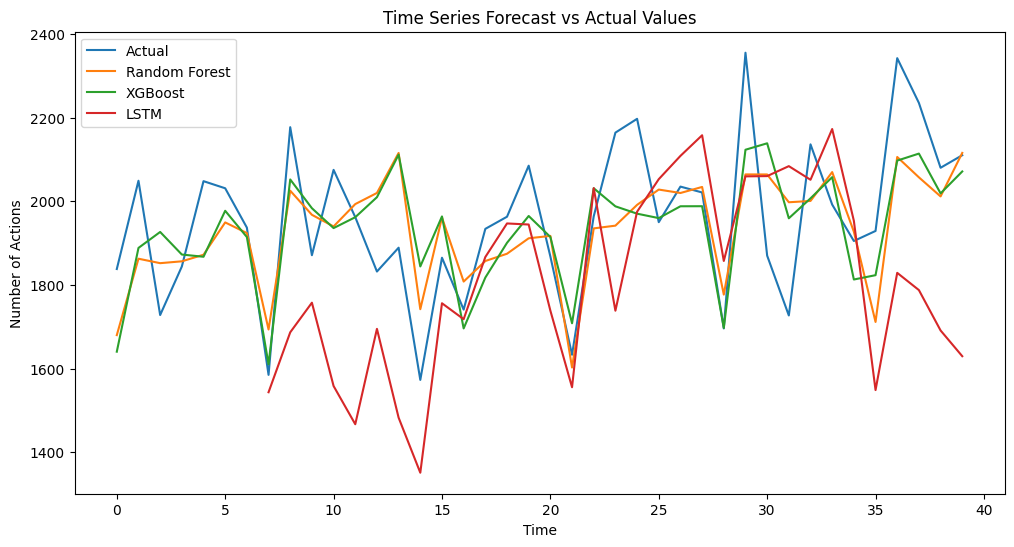

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(rf_predictions, label='Random Forest')
plt.plot(xgb_predictions[:len(y_test)], label='XGBoost')
plt.plot(np.concatenate([np.full(7, np.nan), lstm_predictions.flatten()]), label='LSTM')
plt.legend()
plt.title('Time Series Forecast vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Number of Actions')
plt.show()

# **Summary**
by looking at the graph and our evalutating we can say that the gradiant boosting model did the best job.(the lstm might model have more potenial we need to check it with more training time and better data (more data => data that spread on more time).



# **bold text**

In [116]:
def predict_future_xgboost(model,df,number_of_days=7):
  last_date = df['timestamp'].iloc[-1]
  future_dates = pd.date_range(start=last_date, periods=number_of_days + 1, freq='D')
  future_df = pd.DataFrame({'timestamp': future_dates})
  future_df['day_of_week'] = future_df['timestamp'].dt.dayofweek
  future_df['day_of_week'] = future_df['timestamp'].dt.dayofweek #creating day of the week feature
##df['month'] = df['timestamp'].dt.month ###that might be a good feature (we dont even have full year data so using it might cause problesm)
  future_df['day_of_month'] = future_df['timestamp'].dt.day
##df['day_of_year'] = df['timestamp'].dt.dayofyear ####that might be a good feature (we dont even have full year data so using it will be uesless)

  future_df['day_of_week_sin'] = np.sin(2 * np.pi * future_df['day_of_week'] / 7) # we will use sin and cos because we belive that there is a recurring pattern in the data and it will fit the best
  future_df['day_of_week_cos'] = np.cos(2 * np.pi * future_df['day_of_week'] / 7)
  last_values = df['value'].tail(7).values
  predictions = []



  for i in range(number_of_days): #creating lag fetures for the upcoming days
        current_lags = []

        for lag in range(1, 8):
            if i >= lag:

                current_lags.append(predictions[i - lag])
            else:

                lag_idx = lag - i - 1
                current_lags.append(last_values[lag_idx])

        row_dict = future_df.iloc[i].to_dict()

        for j, lag_val in enumerate(current_lags, 1):
            row_dict[f'lag_{j}'] = lag_val

        if i == 0:

            row_dict['rolling_mean_7'] = np.mean(current_lags)
            row_dict['rolling_std_7'] = np.std(current_lags)
        else:

            values_to_use = current_lags
            row_dict['rolling_mean_7'] = np.mean(values_to_use)
            row_dict['rolling_std_7'] = np.std(values_to_use)

        feature_row = pd.DataFrame([row_dict])
        X_predict = feature_row.drop(['timestamp'], axis=1) #predicting the values
        prediction = model.predict(X_predict)[0]
        predictions.append(prediction)


  return predictions

In [121]:
future_predict_values = predict_future_xgboost(xgb_model,df)
df['timestamp'] = pd.to_datetime(df['timestamp'])
future_dates = pd.date_range(start=df['timestamp'].iloc[-1], periods=7, freq='D')
future_df = pd.DataFrame({'timestamp': future_dates})
future_df['value'] = future_predict_values #preparing data for graph

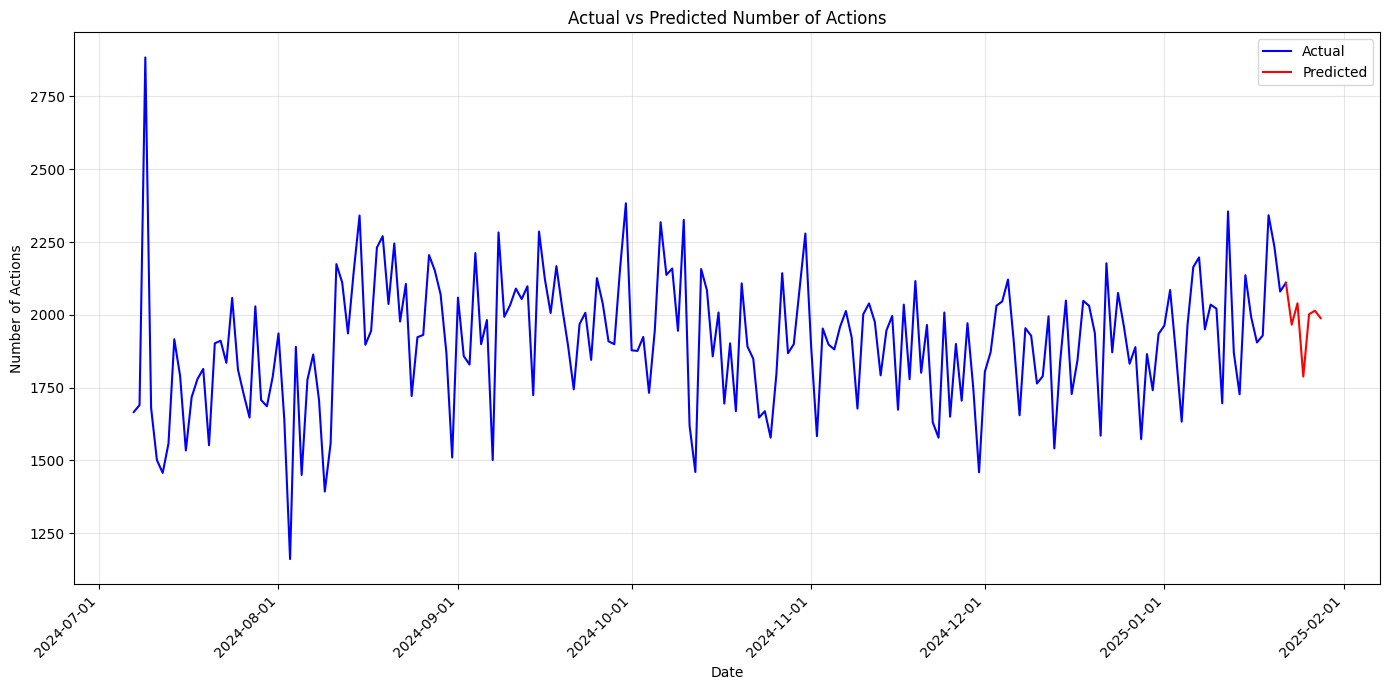

In [124]:
plt.figure(figsize=(14, 7))

plt.plot(df['timestamp'], df['value'], label='Actual', color='blue')
plt.plot(future_df['timestamp'], future_df['value'], label='Predicted', color='red')


plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Number of Actions')
plt.title('Actual vs Predicted Number of Actions')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()
plt.show()

  # **The End**